# Emerging Topics final code - Pandemics

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("../../../../data/prd/Tech-Report/case_studies/pandemic_corpus.pkl")
df = pd.read_pickle("./term-match-corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus -- NEED TO CREATE
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,338,338,380,90045,Study of Emerging Networks in Outbreak Respons...,2008,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,"ANSELL, CHRISTOPHER","KELLER, ANN; REINGOLD, ARTHUR",09,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.075,2008,726706.0,NaN,1,1,"[study, emerge, network, outbreak, responsepri..."
1,464,464,524,90243,One of the products of human development and p...,2008,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,"DASZAK, PETER","KILPATRICK, A MARM",08,077090066,ECOHEALTH ALLIANCE INC,NEW YORK,NY,10001-2320,UNITED STATES,NaN,NaN,47.075,2008,468673.0,NaN,2,2,"[product, human, development, population, grow..."
2,761,761,859,90573,Intellectual merit:The proposed project seeks ...,2008,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,"KOELLE, KATHARINA",NaN,04,044387793,DUKE UNIVERSITY,DURHAM,NC,27705-4010,UNITED STATES,NaN,NaN,47.074,2008,610071.0,NaN,1,1,"[intellectual_merit, propose, project, seek, d..."
3,3300,3300,3661,93669,About five percent of the world's population d...,2008,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,"DENNEHY, JOHN J",NaN,09,064932676,RESEARCH FOUNDATION OF THE CITY UNIVERSITY OF ...,FLUSHING,NY,11367-1575,UNITED STATES,NaN,NaN,47.074,2008,67848.0,NaN,1,1,"[percent, world, population, die, major, influ..."
4,3364,3364,3734,93742,South Africa has the highest rate of HIV/AIDS ...,2008,Address; Affect; Africa; African; AIDS/HIV pro...,DOCTORAL DISSERTATION RESEARCH: IMPACT OF HIV/...,NSF,NSF,NaN,0825414,9/1/2008,2/28/2011,"STEPP, JOHN R","COLES, BRITT",06,019361885,UNIVERSITY OF FLORIDA,GAINESVILLE,FL,32611-2002,UNITED STATES,NaN,NaN,47.075,2008,12000.0,NaN,1,1,"[south_africa, highest, rate, hiv, aids, world..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

stop_wds = ['research', 'study', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 7.5866312980651855


In [9]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('influenza', 4.391461110074189)
('strain', 0.759992209123541)
('virus', 0.5750651187861462)
('vaccination', 0.4694250190480146)
('year', 0.41835538407015577)
('child', 0.3968871412753723)
('population', 0.3116902490777422)
('illness', 0.3001265506860471)
('effectiveness', 0.297720498767584)
('estimate', 0.24756417173341028)

Topic 1:
('hiv', 2.463274243992294)
('aids', 0.35354513665816767)
('infect', 0.24596578234462374)
('infection', 0.22953582152098975)
('transmission', 0.19541472037840016)
('prevention', 0.14145829359894574)
('woman', 0.14125748030316507)
('antiretroviral', 0.1300928345618914)
('incidence', 0.1259421758577883)
('individual', 0.12173998980071199)

Topic 2:
('vaccine', 2.1175922911664196)
('adjuvant', 0.4894390335218088)
('antigen', 0.4566307324067616)
('protective', 0.40270442491189345)
('protection', 0.3867374900556258)
('efficacy', 0.34169950611108035)
('immunity', 0.3315411101711565)
('strain', 0.2964455343118839)
('effective', 0.2717311675664078)
('imm

### Topic Trends

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
sum(df['PROJECT_START_DATE'].isna())

0

In [12]:
df['START_YEAR'].value_counts(dropna=False)

2009    230
2010    229
2011    213
2012    185
2008    164
2014    142
2016    140
2015    140
2017    131
2018    124
2013    118
2007    115
2019    106
2006     55
2003     43
2005     31
2004     29
2001     19
1999     15
2002     13
1997      8
1993      8
1998      8
1990      6
1991      5
1983      4
1992      3
1989      3
1977      3
1987      3
1981      3
1994      3
2000      3
1996      2
1995      1
1980      1
2020      1
1979      1
Name: START_YEAR, dtype: int64

In [13]:
# quick look at abstracts with Topic 9

topic_9_df = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_9_df["START_YEAR"] = df["START_YEAR"].astype(int)

In [27]:
topic_9_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.000000,0.003584,0.003692,0.006140,0.000000,0.000994,0.000719,0.010612,0.001915,0.003389,0.073446,0.000000,0.000000,0.010666,0.000000,0.000000,0.000000,0.001130,0.000000,0.000000,0.000000,0.000000,0.00000,0.008297,0.000000,0.000000,0.000041,0.000000,0.011779,2008
1,0.000000,0.000000,0.001239,0.000000,0.000000,0.005268,0.004141,0.000000,0.005710,0.000000,0.000000,0.092310,0.000000,0.000000,0.028525,0.000000,0.018171,0.000000,0.007547,0.019979,0.000000,0.000000,0.000905,0.00000,0.012592,0.000000,0.000000,0.007005,0.000000,0.000000,2008
2,0.019744,0.007443,0.000000,0.000975,0.000000,0.000000,0.000000,0.000000,0.000000,0.006397,0.000000,0.047016,0.041610,0.000000,0.022236,0.000000,0.001007,0.000000,0.000000,0.000022,0.000000,0.000000,0.022254,0.00000,0.006976,0.013733,0.007989,0.041418,0.000000,0.000000,2008
3,0.000000,0.000000,0.045170,0.000000,0.000000,0.000000,0.000000,0.000000,0.011018,0.000000,0.000000,0.038425,0.005765,0.000000,0.000000,0.000000,0.019057,0.000000,0.000000,0.000000,0.000000,0.003510,0.017647,0.00000,0.002166,0.000000,0.000000,0.001948,0.000000,0.005708,2008
4,0.008935,0.000000,0.057854,0.000000,0.000000,0.000000,0.000000,0.000000,0.004231,0.003504,0.000000,0.038822,0.015763,0.000000,0.021240,0.000000,0.001131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.001476,0.000000,0.000000,0.002402,0.000000,0.001552,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,0.000000,0.004532,0.088879,0.000000,0.028562,0.000000,0.048099,0.015019,0.000000,0.000000,0.002375,0.000000,0.001368,0.000000,0.000000,0.006397,0.000000,0.003527,0.000000,0.000000,0.007323,0.009376,0.000000,0.00000,0.000000,0.000532,0.042062,0.000000,0.008747,0.005493,2017
3835,0.038697,0.000000,0.031014,0.013845,0.051847,0.000000,0.003090,0.000000,0.000000,0.000000,0.000000,0.003337,0.000000,0.000000,0.000971,0.000242,0.014329,0.000000,0.000000,0.003381,0.000623,0.002966,0.000000,0.00000,0.070511,0.000957,0.000000,0.000000,0.010335,0.000000,2017
3836,0.000000,0.000000,0.090739,0.001806,0.000000,0.001017,0.017820,0.000000,0.000000,0.000000,0.000000,0.010223,0.015495,0.000000,0.000000,0.000000,0.003043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000115,0.00334,0.002549,0.000000,0.004535,0.022437,0.008839,0.000000,2012
3837,0.000000,0.000000,0.051031,0.012597,0.000000,0.000000,0.000822,0.000000,0.000000,0.000000,0.000000,0.020778,0.008402,0.001755,0.000000,0.001292,0.005902,0.000000,0.000000,0.000000,0.001438,0.002345,0.000000,0.00000,0.016554,0.000000,0.000000,0.000000,0.000000,0.001120,2012


In [28]:
topic_9_df = topic_9_df[topic_9_df["START_YEAR"] > 2009] 
topic_9_df = topic_9_df[topic_9_df["START_YEAR"] < 2020]

In [58]:
topic_9_df[topic_9_df["Topic 9"] > 0.2]

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
1075,0.009401,0.001070,0.010705,0.000000,0.047044,0.005727,0.006459,0.000000,0.006721,0.208819,0.001782,0.005781,0.008489,0.000000,0.012602,0.001466,0.000000,0.000000,0.000000,0.000000,0.002188,0.000000,0.000000,0.003532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043,2011
1173,0.000000,0.000000,0.015057,0.013799,0.000010,0.005644,0.000000,0.070844,0.000000,0.201999,0.000000,0.000000,0.000000,0.000000,0.001928,0.000225,0.000000,0.023117,0.000000,0.007683,0.000000,0.000000,0.000000,0.000000,0.002127,0.000000,0.030549,0.000000,0.000000,0.000000,2011
1507,0.009401,0.001070,0.010705,0.000000,0.047044,0.005727,0.006459,0.000000,0.006721,0.208819,0.001782,0.005781,0.008489,0.000000,0.012602,0.001466,0.000000,0.000000,0.000000,0.000000,0.002188,0.000000,0.000000,0.003532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043,2011
1512,0.000000,0.000000,0.015057,0.013799,0.000010,0.005644,0.000000,0.070844,0.000000,0.201999,0.000000,0.000000,0.000000,0.000000,0.001928,0.000225,0.000000,0.023117,0.000000,0.007683,0.000000,0.000000,0.000000,0.000000,0.002127,0.000000,0.030549,0.000000,0.000000,0.000000,2011
2158,0.019443,0.000000,0.000000,0.011711,0.000000,0.000000,0.000000,0.000000,0.000000,0.224982,0.000000,0.000000,0.054630,0.000000,0.006392,0.000000,0.014988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010589,0.000000,0.001710,0.010184,0.000000,0.000000,2013
2518,0.000000,0.000000,0.000101,0.004479,0.064024,0.000000,0.003668,0.000000,0.000000,0.241688,0.000000,0.002583,0.013680,0.000000,0.000000,0.000000,0.001240,0.000000,0.000000,0.001829,0.000000,0.002404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015
2519,0.000000,0.000000,0.000000,0.005163,0.065347,0.000000,0.000000,0.000000,0.001033,0.227260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006790,0.000000,0.003126,0.000000,0.000861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015
2587,0.000843,0.001953,0.000790,0.000000,0.027692,0.017378,0.008624,0.000000,0.000250,0.250034,0.000000,0.000000,0.000000,0.000000,0.000000,0.001978,0.000000,0.003234,0.006387,0.000000,0.003473,0.000000,0.000000,0.000832,0.000000,0.000000,0.017303,0.004856,0.013815,0.000000,2015
2687,0.000000,0.000000,0.000000,0.003921,0.058469,0.000000,0.000000,0.000000,0.001283,0.269968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005852,0.000237,0.002584,0.000000,0.001251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016
2744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082393,0.000000,0.235082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019208,0.000000,0.000000,0.009741,0.000000,2016


In [65]:
df["ABSTRACT"].iloc[2749]

'\ufeff   DESCRIPTION (provided by applicant): Influenza A virus (IAV) is an upper respiratory pathogen in humans that causes seasonal epidemics and sporadic pandemics[18-20]. Well known for its promiscuous host species tropism, IAV can infect waterfowl, domestic birds, swine, humans, and sea mammals[21]. IAV strains endemic to waterfowl and domestic animals are capable of spontaneously crossing the species barrier, leading to outbreaks in other host species and even pandemics in humans[22-25]. This adaptability is in part achieved through the inherent low fidelity of the encoded RNA dependent RNA polymerase; however, the host factors that contribute to efficient IAV transmission between species and/or maintain viral fitness upon infection of a new host remain unknown[26, 27]. We have recently identified ADAR1 as a host factor that is essential for optimal IAV replication and progeny fitness. We will further our understanding of the relationship between ADAR1 and IAV by (1) identifying

In [42]:
max(topic_9_df["Topic 9"])

0.2929449067980932

In [14]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [15]:
topic_proj_count = topic_frame.copy()

In [16]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.000000,0.000085,0.003649,0.001782,0.002129,0.001959,0.0,0.065129,0.000000,0.004237,0.000000,0.001776,0.000000,0.0,0.000000,0.004781,0.000000,0.003189,0.003124,0.007338,0.001430,0.0,0.0,0.000000,0.036170,0.005546,0.006113,0.004350,0.022436,2008
1,0.000000,0.000000,0.000595,0.021664,0.000000,0.008780,0.000070,0.0,0.074805,0.018852,0.000000,0.013826,0.001100,0.002961,0.0,0.000000,0.008468,0.015274,0.002169,0.008125,0.000000,0.002605,0.0,0.0,0.000000,0.030241,0.000000,0.033228,0.009059,0.000000,2008
2,0.023193,0.005688,0.003452,0.013190,0.000000,0.000000,0.003136,0.0,0.034355,0.000000,0.002353,0.000457,0.012511,0.000000,0.0,0.000000,0.000000,0.096063,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.043440,0.043915,0.000000,0.000000,0.002286,0.000000,2008
3,0.002531,0.000000,0.000000,0.018273,0.000792,0.000000,0.055015,0.0,0.032014,0.003899,0.001655,0.000000,0.000000,0.000664,0.0,0.000000,0.000000,0.013310,0.001543,0.000000,0.000000,0.000000,0.0,0.0,0.009231,0.030470,0.000000,0.013418,0.000984,0.000000,2008
4,0.000000,0.061390,0.000000,0.010211,0.000000,0.000000,0.000000,0.0,0.050704,0.003337,0.000000,0.000000,0.000000,0.000000,0.0,0.002575,0.013564,0.000000,0.003705,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.011231,0.000000,0.006414,0.008608,0.007174,2008


In [17]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [18]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,False,False,True,True,True,True,True,False,True,False,True,False,True,False,False,False,True,False,True,True,True,True,False,False,False,True,True,True,True,True,2008
1,False,False,True,True,False,True,True,False,True,True,False,True,True,True,False,False,True,True,True,True,False,True,False,False,False,True,False,True,True,False,2008
2,True,True,True,True,False,False,True,False,True,False,True,True,True,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,2008
3,True,False,False,True,True,False,True,False,True,True,True,False,False,True,False,False,False,True,True,False,False,False,False,False,True,True,False,True,True,False,2008
4,False,True,False,True,False,False,False,False,True,True,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,True,True,True,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,True,True,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,True,False,True,False,False,True,False,True,2017
2304,False,False,True,True,True,True,False,False,False,False,False,True,False,True,True,False,True,False,False,True,True,True,False,False,False,True,True,False,False,False,2017
2305,True,True,True,False,False,True,True,False,True,True,True,False,False,True,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,False,2018
2306,False,True,False,False,True,True,True,True,True,False,False,False,True,True,False,False,False,True,True,False,True,False,True,True,True,False,True,True,True,True,2018


In [19]:
topic_count_bool.sum(axis=1).median()

12.0

In [20]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [21]:
#topic_counts

In [22]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [23]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,120,103,107,94,95,95,102,80,111,92,66,84,97,86,73,86,88,95,80,86,95,128,79,76,83,85,56,74,84,99
28,2011,110,90,100,76,83,73,101,58,120,97,51,78,72,66,65,68,81,89,49,85,80,100,51,81,79,76,48,65,71,89
29,2012,90,70,84,62,76,106,84,70,108,71,46,69,77,77,73,57,72,88,65,97,66,96,67,79,98,65,53,84,74,69
30,2013,57,37,43,47,60,55,48,50,55,47,36,47,37,49,46,49,45,53,50,45,50,69,46,41,50,38,30,41,40,51
31,2014,68,45,63,28,50,62,58,55,54,65,55,53,52,44,63,38,59,52,36,57,43,55,45,53,50,40,37,44,47,46
32,2015,68,45,62,40,65,57,63,53,70,47,48,47,46,59,54,47,50,57,49,57,51,70,38,46,64,45,36,53,50,60
33,2016,65,52,61,39,55,56,69,45,67,48,42,47,52,62,50,44,50,74,41,62,65,63,56,51,61,46,39,48,51,53
34,2017,53,54,64,43,66,55,65,42,59,46,37,52,49,61,58,39,51,69,41,45,59,65,50,50,62,49,44,52,52,62
35,2018,62,38,62,49,60,63,67,31,55,42,47,55,45,51,53,43,49,52,37,50,59,61,46,42,40,46,26,46,45,48
36,2019,54,39,50,42,48,50,44,35,44,39,39,50,36,41,44,36,42,39,30,36,52,47,38,45,40,30,34,30,36,42


In [24]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     747
Topic 1     573
Topic 2     696
Topic 3     520
Topic 4     658
Topic 5     672
Topic 6     701
Topic 7     519
Topic 8     743
Topic 9     594
Topic 10    467
Topic 11    582
Topic 12    563
Topic 13    596
Topic 14    579
Topic 15    507
Topic 16    587
Topic 17    668
Topic 18    478
Topic 19    620
Topic 20    620
Topic 21    754
Topic 22    516
Topic 23    564
Topic 24    627
Topic 25    520
Topic 26    403
Topic 27    537
Topic 28    550
Topic 29    619
dtype: int64

In [25]:
n_by_topic[0]

747

#### compute dollars by topic by year

#### calculate mean topic weight by year and standard errors on means

In [26]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [27]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [28]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1977,0.015806,0.017300,0.000000,0.000000,0.000000,0.000382,0.026622,0.000000,0.000000,0.001404,0.000310,0.000000,0.000188,0.000000,0.000284,0.000000,0.000585,0.003077,0.000000,0.000000,0.000000,0.002452,0.074773,0.000000,0.206389,0.002573,0.012433,0.000000,0.000000,0.000000
1,1979,0.003851,0.001553,0.000000,0.000000,0.000000,0.008240,0.000000,0.013638,0.013800,0.000000,0.000000,0.001851,0.024005,0.000000,0.025233,0.010281,0.000000,0.000000,0.000000,0.001752,0.000000,0.000000,0.120016,0.000000,0.019628,0.000000,0.006246,0.000087,0.000000,0.000000
2,1980,0.000722,0.000000,0.000990,0.000000,0.000000,0.000000,0.000000,0.000000,0.015475,0.012406,0.004316,0.000437,0.057929,0.011777,0.000000,0.000672,0.000000,0.075639,0.000642,0.000000,0.002740,0.000000,0.000000,0.003427,0.000000,0.000000,0.004518,0.022200,0.001564,0.002549
3,1981,0.000000,0.013717,0.006252,0.000491,0.015340,0.010421,0.000220,0.011509,0.005569,0.000000,0.000000,0.004270,0.015279,0.002040,0.003749,0.005544,0.001209,0.008972,0.002437,0.004660,0.007189,0.000000,0.002818,0.019829,0.035690,0.000000,0.004786,0.118042,0.034954,0.000282
4,1983,0.053909,0.005149,0.002658,0.003938,0.001361,0.009161,0.084262,0.000000,0.000313,0.000000,0.000000,0.000653,0.000708,0.000000,0.000000,0.002746,0.000266,0.000000,0.001151,0.001813,0.000000,0.000000,0.002792,0.000000,0.145202,0.004921,0.004642,0.000000,0.000000,0.000000


In [29]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [30]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,0.010836,0.024679,0.013998,0.006819,0.011727,0.008053,0.011937,0.004067,0.009541,0.004834,0.003547,0.003314,0.004536,0.008974,0.005814,0.007748,0.003461,0.006635,0.006088,0.008400,0.009341,0.014837,0.006811,0.007753,0.013481,0.006298,0.004688,0.006134,0.003438,0.018386
28,2011,0.013195,0.025411,0.019391,0.005231,0.009414,0.009717,0.012364,0.003180,0.012524,0.005982,0.005023,0.003981,0.005070,0.003907,0.004130,0.007660,0.003964,0.009382,0.004775,0.012361,0.008658,0.010683,0.005757,0.007051,0.014629,0.008908,0.002723,0.008831,0.004516,0.015913
29,2012,0.010864,0.022676,0.018026,0.003471,0.008265,0.013171,0.014192,0.006666,0.007751,0.002541,0.002856,0.003517,0.004650,0.009548,0.004744,0.007313,0.003763,0.007829,0.004571,0.010450,0.007937,0.019121,0.009914,0.005543,0.013452,0.011056,0.006918,0.008060,0.005610,0.011199
30,2013,0.010257,0.016053,0.012018,0.004814,0.011840,0.010540,0.014346,0.008434,0.008743,0.003146,0.005735,0.003842,0.005491,0.015141,0.006357,0.013330,0.004427,0.007292,0.006684,0.005115,0.008912,0.013725,0.005535,0.007475,0.010013,0.007236,0.001898,0.003523,0.004836,0.019017
31,2014,0.010016,0.017878,0.015690,0.003319,0.008588,0.005537,0.011177,0.005204,0.012879,0.015419,0.005622,0.003949,0.004812,0.012682,0.010359,0.008034,0.015655,0.010949,0.002731,0.007110,0.008399,0.009546,0.006875,0.008411,0.007559,0.007598,0.004024,0.005657,0.009433,0.015464
32,2015,0.012566,0.017293,0.012045,0.004587,0.007360,0.010171,0.012585,0.007301,0.012911,0.002672,0.009466,0.003399,0.005219,0.011736,0.011702,0.006953,0.003547,0.009882,0.001577,0.003150,0.007798,0.009705,0.006638,0.009095,0.012007,0.009216,0.004481,0.006887,0.011508,0.019114
33,2016,0.009648,0.020543,0.012517,0.004266,0.008123,0.009197,0.009540,0.007760,0.010299,0.003062,0.013936,0.003427,0.005413,0.010337,0.008248,0.005795,0.003042,0.013371,0.002416,0.007650,0.009589,0.009757,0.011838,0.008890,0.009980,0.010252,0.007088,0.007768,0.009508,0.012418
34,2017,0.010100,0.012796,0.011505,0.007105,0.008893,0.007317,0.009935,0.007551,0.007895,0.002978,0.012962,0.003878,0.004516,0.011741,0.010870,0.003949,0.002412,0.013864,0.007463,0.006109,0.007285,0.010727,0.009091,0.008090,0.010914,0.010570,0.006925,0.010486,0.010332,0.010806
35,2018,0.011429,0.012491,0.020529,0.003839,0.009751,0.010449,0.009071,0.003796,0.006197,0.002702,0.020336,0.005773,0.002890,0.009616,0.010235,0.005049,0.002824,0.011692,0.015205,0.005623,0.010546,0.012890,0.008700,0.007026,0.008723,0.011928,0.008789,0.007580,0.014218,0.011609
36,2019,0.011489,0.019030,0.019377,0.001508,0.006056,0.009297,0.009313,0.005241,0.007725,0.003582,0.020791,0.005168,0.002289,0.015982,0.010002,0.003953,0.003035,0.006405,0.008818,0.004477,0.009320,0.011928,0.012268,0.011080,0.012311,0.011991,0.012565,0.003552,0.015512,0.009844


In [31]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,0.001240,0.002972,0.001863,0.001066,0.002038,0.001323,0.001726,0.001007,0.001175,0.001466,0.001180,0.001279,0.001505,0.001999,0.001088,0.001621,0.000655,0.000805,0.002090,0.001846,0.001746,0.001684,0.001860,0.002290,0.002191,0.001216,0.001646,0.001793,0.001027,0.003185
28,2011,0.001424,0.003375,0.002472,0.001021,0.001850,0.001942,0.001767,0.001042,0.001527,0.001586,0.001742,0.001424,0.001673,0.001237,0.000750,0.002060,0.000684,0.001354,0.001885,0.002908,0.001943,0.001469,0.001966,0.002309,0.002439,0.002276,0.001413,0.002710,0.001110,0.002653
29,2012,0.001309,0.003294,0.002583,0.000834,0.001707,0.001791,0.002132,0.001476,0.000987,0.000462,0.001072,0.001606,0.001805,0.002001,0.000989,0.002457,0.000643,0.000983,0.001318,0.001978,0.002187,0.002554,0.002595,0.002212,0.002192,0.003216,0.002564,0.001358,0.001722,0.002646
30,2013,0.001504,0.003521,0.002596,0.001446,0.002639,0.002370,0.002714,0.003082,0.001622,0.000582,0.002571,0.002402,0.002819,0.003497,0.001490,0.004053,0.000870,0.001470,0.002821,0.001407,0.003322,0.002321,0.001572,0.003567,0.001860,0.004208,0.000608,0.000732,0.001677,0.004653
31,2014,0.001337,0.003446,0.002761,0.001206,0.001797,0.000999,0.002195,0.002546,0.002602,0.004972,0.002114,0.002031,0.002316,0.003491,0.002112,0.002967,0.005050,0.003453,0.001664,0.001955,0.002809,0.001888,0.001928,0.003206,0.001684,0.003723,0.001346,0.002296,0.003428,0.003882
32,2015,0.001814,0.003506,0.002151,0.001452,0.001346,0.002516,0.002240,0.002694,0.002204,0.000481,0.003440,0.002035,0.002374,0.002819,0.002335,0.002338,0.000654,0.002855,0.000355,0.000662,0.002589,0.001693,0.002005,0.003578,0.002289,0.003852,0.001550,0.002123,0.003853,0.004119
33,2016,0.001528,0.003882,0.002165,0.001278,0.001732,0.001986,0.001643,0.002777,0.001640,0.000705,0.004087,0.002034,0.002373,0.002756,0.002033,0.002324,0.000628,0.003764,0.001030,0.002039,0.002510,0.001643,0.002718,0.003108,0.002130,0.004165,0.003147,0.002638,0.003803,0.003075
34,2017,0.001598,0.002967,0.002097,0.002091,0.001551,0.001781,0.001972,0.002898,0.001518,0.000635,0.004198,0.002111,0.002478,0.002726,0.002448,0.001332,0.000490,0.004029,0.003574,0.001798,0.002655,0.001941,0.002056,0.003018,0.002673,0.004344,0.003224,0.004190,0.004315,0.002435
35,2018,0.001653,0.003374,0.003340,0.001098,0.001970,0.002101,0.001592,0.001413,0.001264,0.000695,0.004853,0.002271,0.000538,0.002659,0.002350,0.001255,0.000459,0.004171,0.005123,0.001461,0.002987,0.002497,0.002869,0.003068,0.001914,0.004426,0.004301,0.003307,0.005702,0.002769
36,2019,0.001704,0.004256,0.003192,0.000334,0.001097,0.002311,0.001830,0.001869,0.001735,0.000799,0.005736,0.002574,0.000481,0.004322,0.002628,0.000969,0.000615,0.001272,0.003942,0.001313,0.003183,0.002242,0.004214,0.003906,0.002859,0.005204,0.005210,0.001019,0.006668,0.002239


In [32]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [33]:
topic_slopes[:5]

[-5.803287211090564e-05,
 -0.0010774703813785497,
 0.00013100362500262255,
 -0.00024093371279586268,
 -0.00035104502216065517]

In [34]:
p_values[:5]

[0.6731672510271182,
 0.017953081653933924,
 0.7582392218356973,
 0.20281886307407232,
 0.07186035937663912]

In [35]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [36]:
leg[:5]

['influenza, strain, virus, vaccination, year',
 'hiv, aids, infect, infection, transmission',
 'vaccine, adjuvant, antigen, protective, protection',
 'training, program, trainee, faculty, student',
 'cell, memory, cd4, subset, selectin']

In [37]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "P%d" % (i+1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [38]:
reg_topics

,Label,Slopex100,p-value,Topic Words
16,P1,-0.021110,0.652984,"animal, bird, surveillance, close, contact"
14,P2,0.071562,0.007476,"antibody, ha, epitope, bind, human"
28,P3,0.131078,0.000031,"cancer, aoic, co_infection, aids, associate"
4,P4,-0.035105,0.071860,"cell, memory, cd4, subset, selectin"
15,P5,-0.056321,0.051217,"core, support, investigator, method, technology"
19,P6,-0.060930,0.038083,"diagnostic, poc, detection, lrs, technology"
23,P7,0.028750,0.075083,"dna, vaccine, boost, testing, vrc"
5,P8,-0.007484,0.762958,"drug, resistance, inhibitor, compound, antiviral"
26,P9,0.078433,0.011746,"env, trimer, clade, hiv, gag"
11,P10,0.017727,0.037562,"facility, product, manufacturing, material, va..."


In [39]:
reg_topics.to_csv("./TM_pan_topics.csv", index=False)

## Grid Plot

In [40]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [41]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(10, 0.002068851619215301),
 (28, 0.0013107753589686533),
 (26, 0.000784334252896272),
 (14, 0.000715623715422465),
 (13, 0.0005978390016483274)]

In [42]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[10,
 28,
 26,
 14,
 13,
 18,
 22,
 25,
 17,
 23,
 11,
 2,
 7,
 20,
 27,
 0,
 5,
 16,
 12,
 3,
 9,
 8,
 4,
 24,
 21,
 6,
 15,
 19,
 29,
 1]

In [43]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [44]:
new_leg

['influenza, strain, virus, \n vaccination, year',
 'hiv, aids, infect, \n infection, transmission',
 'vaccine, adjuvant, antigen, \n protective, protection',
 'training, program, trainee, \n faculty, student',
 'cell, memory, cd4, \n subset, selectin',
 'drug, resistance, inhibitor, \n compound, antiviral',
 'virus, human, influenza, \n 1918, swine',
 'inhibitor, entry, hlv, \n molecule, fusion',
 'intervention, model, social, \n health, disease',
 'influenza, ecologic, cross_protection, \n immune, environmental',
 'iav, response, sp, \n cd1c_dc, htbe',
 'facility, product, manufacturing, \n material, vaccine',
 'organism, gene, sequence, \n ortholog, genome',
 'obesity, insulin, diabete, \n metabolic, obese',
 'antibody, ha, epitope, \n bind, human',
 'core, support, investigator, \n method, technology',
 'animal, bird, surveillance, \n close, contact',
 'viral, host, evolution, \n pathogen, evolutionary',
 'tb, mtb, tuberculosis_tb, \n treatment, tuberculosis',
 'diagnostic, poc, de

In [45]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [46]:
order_df

,Topic Words
0,"influenza, strain, virus, vaccination, year"
1,"hiv, aids, infect, infection, transmission"
2,"vaccine, adjuvant, antigen, protective, protec..."
3,"training, program, trainee, faculty, student"
4,"cell, memory, cd4, subset, selectin"
5,"drug, resistance, inhibitor, compound, antiviral"
6,"virus, human, influenza, 1918, swine"
7,"inhibitor, entry, hlv, molecule, fusion"
8,"intervention, model, social, health, disease"
9,"influenza, ecologic, cross_protection, immune,..."


In [47]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [48]:
L_df

,Topic Words,Label
0,"influenza, strain, virus, vaccination, year",P14
1,"hiv, aids, infect, infection, transmission",P11
2,"vaccine, adjuvant, antigen, protective, protec...",P28
3,"training, program, trainee, faculty, student",P26
4,"cell, memory, cd4, subset, selectin",P4
5,"drug, resistance, inhibitor, compound, antiviral",P8
6,"virus, human, influenza, 1918, swine",P30
7,"inhibitor, entry, hlv, molecule, fusion",P15
8,"intervention, model, social, health, disease",P16
9,"influenza, ecologic, cross_protection, immune,...",P13


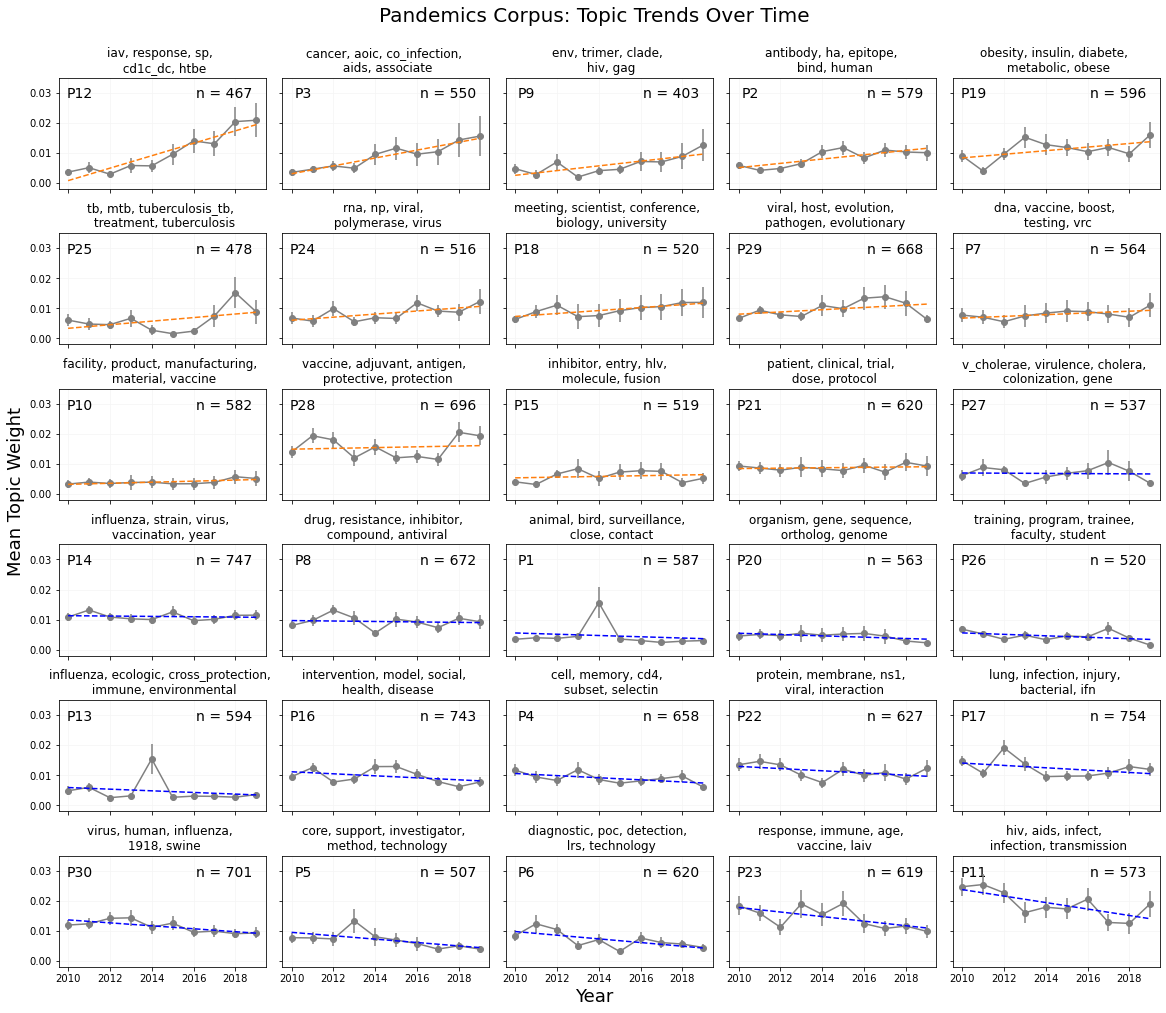

In [49]:
# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.035)  

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.80, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Pandemics Corpus: Topic Trends Over Time', fontsize = 20)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 18)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig("TM_pan_topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

In [50]:
# get legend items for too long titles (topic 2)

new_leg[sorted_slopes[16]-1]
new_leg[sorted_slopes[27]-1]


'tb, mtb, tuberculosis_tb, \n treatment, tuberculosis'

### Descriptive statistics on corpus

In [51]:
df["START_YEAR"].value_counts()

2009    230
2010    229
2011    213
2012    185
2008    164
2014    142
2016    140
2015    140
2017    131
2018    124
2013    118
2007    115
2019    106
2006     55
2003     43
2005     31
2004     29
2001     19
1999     15
2002     13
1997      8
1993      8
1998      8
1990      6
1991      5
1983      4
1992      3
1989      3
1977      3
1987      3
1981      3
1994      3
2000      3
1996      2
1995      1
1980      1
2020      1
1979      1
Name: START_YEAR, dtype: int64

In [52]:
df["DEPARTMENT"].value_counts()

HHS     2157
NSF       93
USDA      34
DOD       18
VA         5
NASA       1
Name: DEPARTMENT, dtype: int64

In [53]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [54]:
year_counts = filt_df["START_YEAR"].value_counts().sort_index()
print(year_counts)

2010    229
2011    213
2012    185
2013    118
2014    142
2015    140
2016    140
2017    131
2018    124
2019    106
Name: START_YEAR, dtype: int64


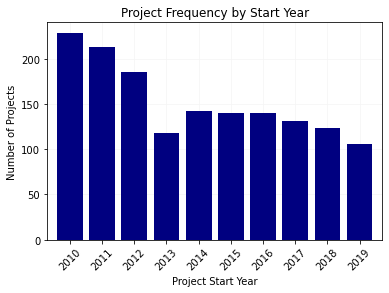

In [55]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
plt.xlim(2009.3,2019.7)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Start Year");

#plt.savefig("pan_startyr_freq.png", dpi = 800, bbox_inches = "tight")

In [56]:
agency_counts = filt_df["DEPARTMENT"].value_counts()
print(agency_counts)

HHS     1418
NSF       67
USDA      21
DOD       18
VA         3
NASA       1
Name: DEPARTMENT, dtype: int64


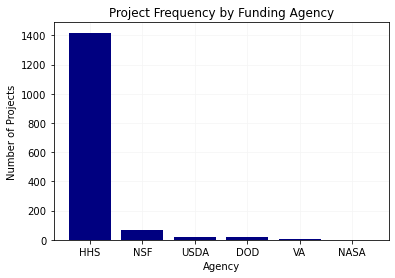

In [57]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
plt.xlabel("Agency")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Funding Agency");

#plt.savefig("pan_agency_dist.png", dpi = 800, bbox_inches = "tight")

In [58]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2010            1
            2015            2
            2017            3
            2018            9
            2019            3
HHS         2010          210
            2011          198
            2012          173
            2013          109
            2014          135
            2015          126
            2016          132
            2017          119
            2018          113
            2019          103
NASA        2012            1
NSF         2010           12
            2011            9
            2012            7
            2013            5
            2014            6
            2015           11
            2016            7
            2017            8
            2018            2
USDA        2010            6
            2011            6
            2012            4
            2013            2
            2014            1
            2015            1
            2016            1
VA          2013 

In [59]:
filt_df.shape

(1528, 33)

## Scratch work 

**try other ways to show topic prevalence, number of projects, project costs**

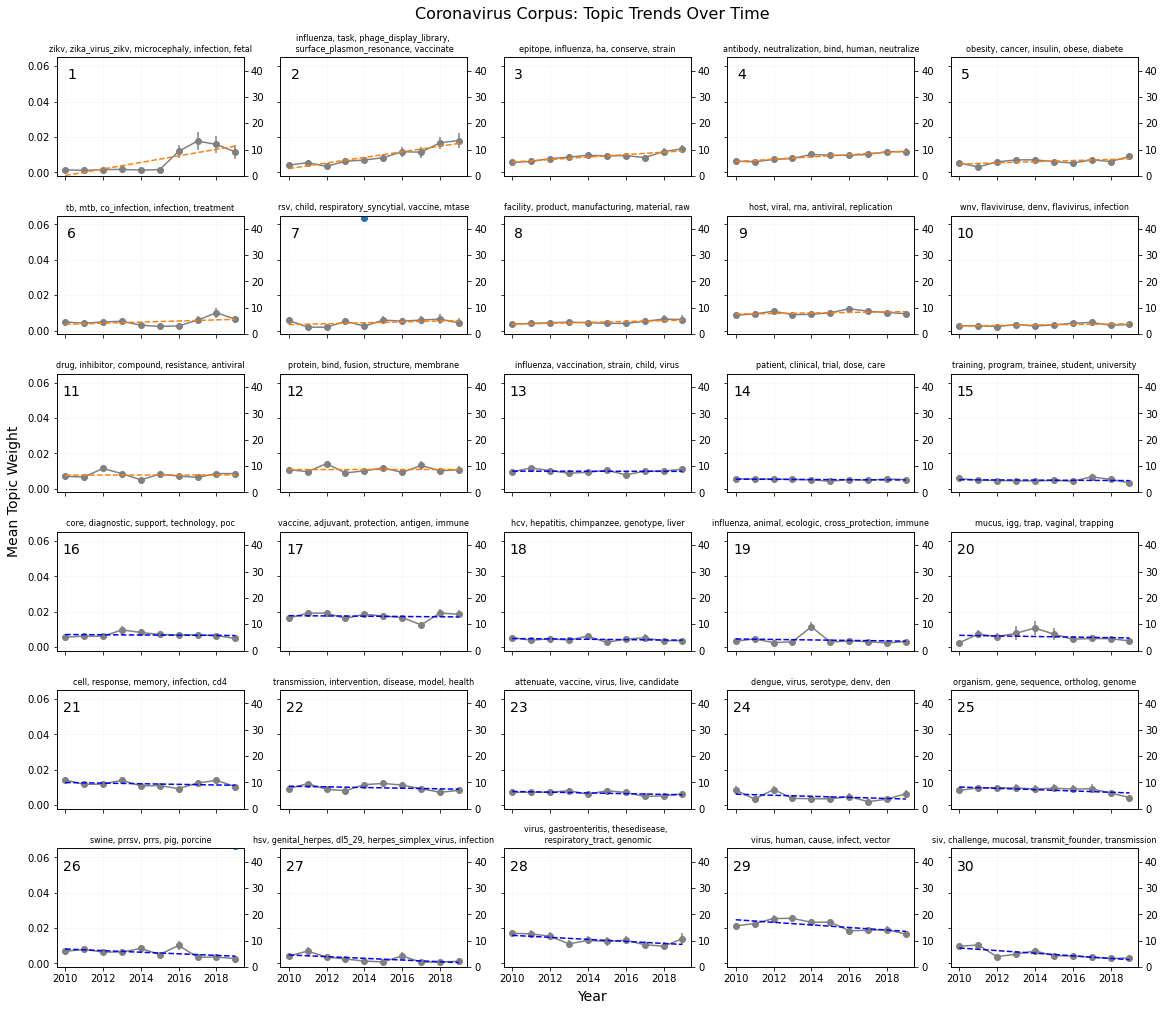

In [61]:
# dual axis approach

# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # try dual axis
    ax2 = ax[i,j].twinx()
    ax2.plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax2.set_ylim(0,45)
    

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

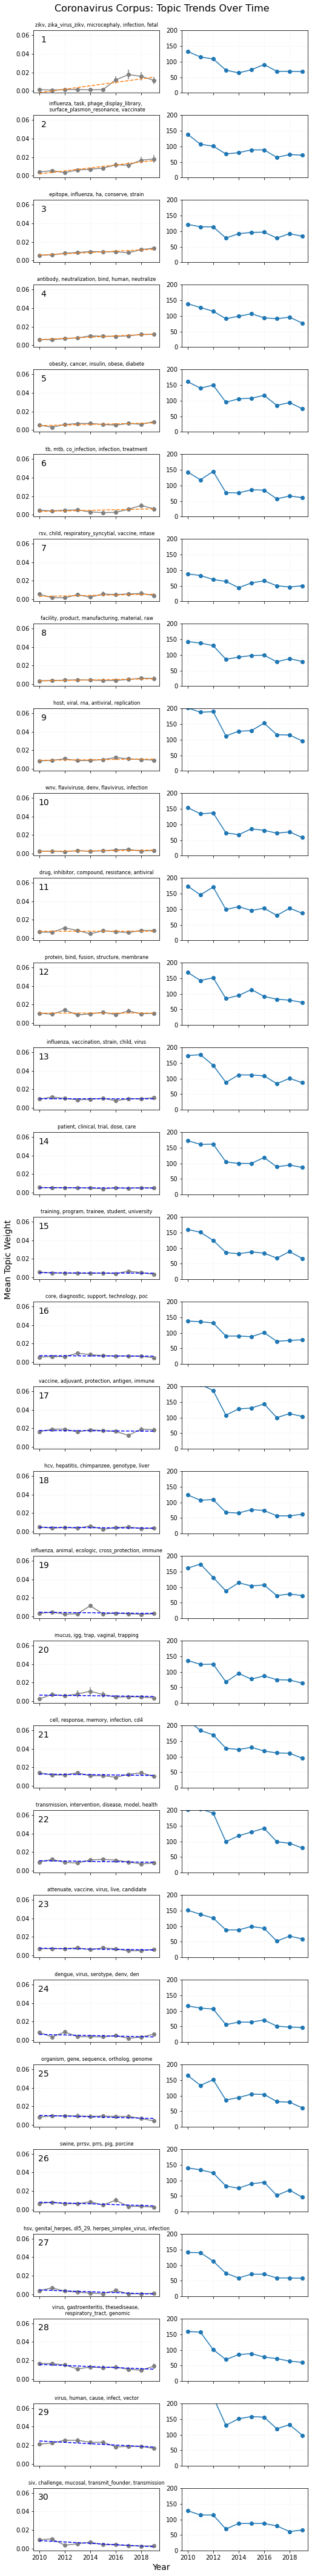

In [64]:
# try with multiple graphs per topic

# set up grid
fig, ax = plt.subplots(30, 2, sharex = True, sharey = 'col', figsize=(7,60))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plots for each row
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # 1: mean topic weights plot
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[count,0].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[count,0].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[count,0].grid(color = "whitesmoke")
    
    # put title on two lines for topics 2, 28
    if count == 1:
        ax[count,0].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[count,0].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[count,0].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[count,0].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[count,0].transAxes, fontsize = 14)
    
    ax[count,0].set_ylim(-0.002,0.065)
    
    # 2. Number of projects plot

    ax[count,1].plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax[count,1].set_ylim(0,200)
    ax[count,1].grid(color = "whitesmoke")
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.97)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()